# Cross-frequency coupling *for the practicing neuroscientist*

<div class="question">
    
_**Synopsis**_ 

**Data:** 100 s of local field potential data sampled at 1000 Hz.

**Goal:** Characterize the coupling between rhythms of different frequency.

**Tools:** Hilbert transform, analytic signal, instantaneous phase, cross-frequency coupling.

</div>


* [Introduction](#introduction)
* [Data Analysis](#data-analysis)
    * [Visual inspection](#visual-inspection)
    * [Spectral analysis](#spectral-analysis)
    * [Cross frequency coupling](#cfc)
        1. [Filter the data into high- and low-frequency bands.](#step1)
        2. [Extract the amplitude and phase from the filtered signals.](#step2)
            * [What does the Hilbert transform do?](#hilbert)
        3. [Determine if the phase and amplitude are related](#step3)
            * [The phase-amplitude plot](#m1) 
* [Summary](#summary)
* [Appendix](#appendix)

## On-ramp: computing cross-frequency coupling in Python
We begin this module with an "*on-ramp*" to analysis. The purpose of this on-ramp is to introduce you immediately to a core concept in this module: how to compute cross-frequency coupling (CFC) in Python. You may not understand all aspects of the program here, but that's not the point. Instead, the purpose of this on-ramp is to  illustrate what *can* be done. Our advice is to simply run the code below and see what happens ...

In [1]:
from scipy.io import loadmat
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

data = loadmat('LFP-1.mat')          # Load the LFP data, 
t = data['t'][0]                     # ... extract t, the time variable,
LFP = data['LFP'][0]                 # ... and LFP, the voltage variable,
dt = t[1] - t[0]                     # Define the sampling interval,
fNQ = 1 / dt / 2                     # ... and Nyquist frequency. 

Wn = [5,7];                          # Set the passband [5-7] Hz,
n = 100;                             # ... and filter order,
b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vlo = signal.filtfilt(b, 1, LFP);    # ... and apply it to the data.

Wn = [80, 120];                      # Set the passband [80-120] Hz,
n = 100;                             # ... and filter order,
b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vhi = signal.filtfilt(b, 1, LFP);    # ... and apply it to the data.

phi = np.angle(signal.hilbert(Vlo))  # Compute phase of low-freq signal
amp = abs(signal.hilbert(Vhi))       # Compute amplitude of high-freq signal

p_bins = np.arange(-np.pi,np.pi,0.1) # To compute CFC, define phase bins,
a_mean = np.zeros(np.size(p_bins)-1) # ... variable to hold the amplitude,
p_mean = np.zeros(np.size(p_bins)-1) # ... and variable to hold the phase.
for k in range(np.size(p_bins)-1):      # For each phase bin,
    pL = p_bins[k]					    #... get lower phase limit,
    pR = p_bins[k+1]				    #... get upper phase limit.
    indices=(phi>=pL) & (phi<pR)	    #Find phases falling in this bin,
    a_mean[k] = np.mean(amp[indices])	#... compute mean amplitude,
    p_mean[k] = np.mean([pL, pR])		#... save center phase.
plt.plot(p_mean, a_mean)                #Plot the phase versus amplitude,
plt.ylabel('High-frequency amplitude')  #... with axes labeled.
plt.xlabel('Low-frequency phase')
plt.title('CFC');

<div class="question">

**Q:** Try to read the code above. Can you see how it loads data, computes the phase and amplitude of the signals, and assess the cross-frequency coupling?

**A:** If you've never computed cross-frequency coupling before, that's an especially difficult question. Please continue on to learn this **and more**!

</div>

## Introduction<a id="introduction"></a>

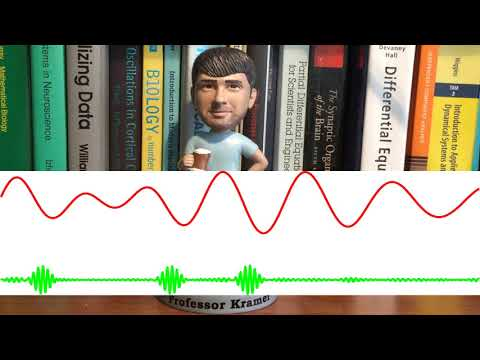

In [2]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('Q-VQaY6iDMM')

### Background

In this module, we focus on local field potential (LFP) recordings. The LFP is a measure of local population neural activity, [produced from small aggregates of neurons](https://www.ncbi.nlm.nih.gov/pubmed/22595786). In these data, we examine the association between rhythms of different frequencies.

In general, lower-frequency rhythms have been observed to engage larger brain areas and modulate spatially localized fast oscillations (see, [for example](https://www.ncbi.nlm.nih.gov/pubmed/18388295)). Of the different types of cross-frequency coupling [(CFC) observced between brain rhythms](https://www.ncbi.nlm.nih.gov/pubmed/26549886), perhaps the most is **phase-amplitude coupling** (PAC), in which the phase of a low frequency rhythm modulates the amplitude (or power) of a high frequency rhythm. Cross-frequency coupling been observed in many brain regions, has been shown to change in time with task demands, and has been proposed to serve a [functional role](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359652/) in working memory, neuronal computation, communication, and learning. Although the cellular and dynamic mechanisms of specific rhythms associated with CFC are relatively well understood, the mechanisms governing interactions between different frequency rhythms - and the appropriate techniques for measuring CFC - remain active research areas. Although we consider only a single electrode recording here, we note that these techniques can be extended to association measures between electrodes as well.

### Case Study Data
We are approached by a collaborator recording the local field potential (LFP) from rat hippocampus. She has implanted a small bundle of electrodes, which remain (chronically) implanted as the rat explores a large circular arena. She is interested in assessing the association between different frequency rhythms of the LFP, and more specifically whether an association between different frequency rhythms exists as the rat explores the arena. To address this question, she has provided us with 100 s of LFP data recorded during the experiment (i.e., while the rat spontaneously explored the arena).

### Goal
Our goal is to assess the associations between different frequency rhythms recorded in the LFP. To do so, we analyze the LFP data by computing the phase-amplitude coupling (CFC) of the time series. We construct two CFC measures that characterize how the phase of a low-frequency signal modulates the amplitude envelope of a high-frequency signal. 

### Tools
In this chapter, we develop two CFC measures, with a particular focus on phase-amplitude coupling (PAC). We introduce the concepts of the Hilbert transform, analytic signal, instantaneous phase, and amplitude envelope.

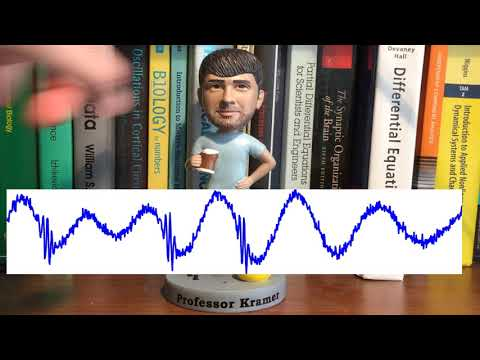

In [3]:
YouTubeVideo('mLglqyb55_Y')

## Data Analysis<a id="data-analysis"></a>

### Visual Inspection
Let's begin with visual inspection of the LFP data.

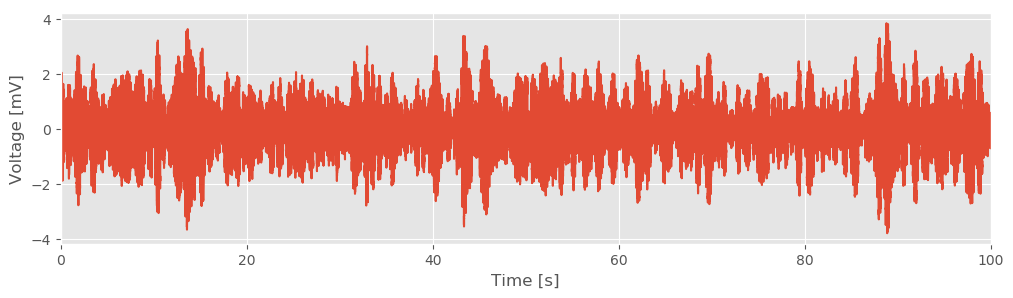

In [4]:
# Load the modules and set plot defaults
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (12,3)
rcParams['axes.xmargin'] = 0

data = loadmat('LFP-1.mat')  # Load the LFP data, 
t = data['t'][0]             # ... extract t, the time variable,
LFP = data['LFP'][0]         # ... and LFP, the voltage variable,
plt.plot(t, LFP)             # ... and plot the trace,
plt.xlabel('Time [s]')       # ... with axes labeled.
plt.ylabel('Voltage [mV]');

Next, let's take a closer look at an example 1 s interval of the data<a id="fig:7.1"></a>:

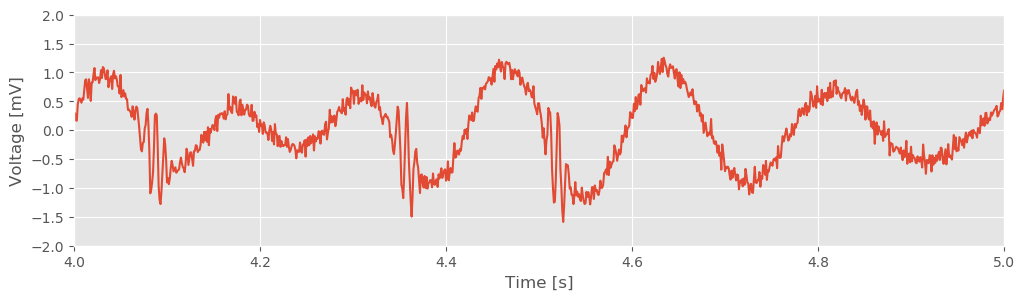

In [5]:
plt.plot(t, LFP)            # Plot the LFP data,
plt.xlim([4, 5])            # ... restrict the x-axis to a 1 s interval,
plt.ylim([-2, 2])           # ... and tighten the y-axis.
plt.xlabel('Time [s]')      # Label the axes
plt.ylabel('Voltage [mV]')
plt.show()

Visual inspection immediately suggests a dominant low-frequency rhythm interspersed with smaller-amplitude blasts of high-frequency activity.

<div class="question">
    
**Q.** Approximate features of the rhythmic activity by visual inspection of the plot above. What is the frequency of the large-amplitude rhythm? Do you observe high-frequency activity? If so, where in time, and at what approximate frequency? What is the sampling frequency of these data? If you were to compute the spectrum of the entire dataset (100 s of LFP), what would be the <abbr title="The Nyquist frequency is the highest frequency we can possibly hope to observe in the data.">Nyquist frequency</abbr> and the <abbr title="This tells us how fine our estimates of the spectrum will be.">frequency resolution</abbr>? *Hint:* Consider the times near 4.35 s and 4.5 s. Do you see the transient fast oscillations?
    
</div>

### Spectral Analysis<a id="spectral-analysis"></a>
Visual inspection of the LFP data suggests that multiple rhythms appear. To further characterize this observation, we compute the spectrum of the LFP data. We analyze the entire 100 s of data and compute the spectrum with a Hanning taper.<a id="fig:7.1"></a>

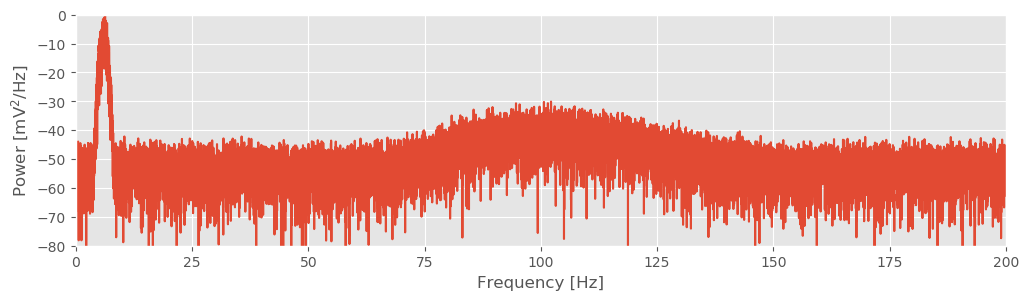

In [6]:
import numpy as np                   # Import the NumPy module
dt = t[1] - t[0]                     # Define the sampling interval,
T = t[-1]                            # ... the duration of the data,
N = len(LFP)                         # ... and the no. of data points

x = np.hanning(N) * LFP              # Multiply data by a Hanning taper
xf = np.fft.rfft(x - x.mean())       # Compute Fourier transform
Sxx = 2*dt**2/T * (xf*np.conj(xf))   # Compute the spectrum
Sxx = np.real(Sxx)                   # Ignore complex components

df = 1 / T                           # Define frequency resolution,
fNQ = 1 / dt / 2                     # ... and Nyquist frequency. 

faxis = np.arange(0, fNQ + df, df)   # Construct freq. axis
plt.plot(faxis, 10 * np.log10(Sxx))  # Plot spectrum vs freq.
plt.xlim([0, 200])                   # Set freq. range, 
plt.ylim([-80, 0])                   # ... and decibel range
plt.xlabel('Frequency [Hz]')         # Label the axes
plt.ylabel('Power [mV$^2$/Hz]');

The resulting spectrum reveals two intervals of increased power spectral density. The lowest-frequency peak at 6 Hz is also the largest and corresponds to the slow rhythm we observe dominating the signal through visual inspection. Remember a plot of that signal:
<a href="#fig:7.1" class="fig"><span><img src="imgs/7-1.png"></span></a>
At higher frequencies, we find an additional broadband peak at approximately 80–120 Hz. These spectral results support our initial visual inspection of the signal; there exist both low- and high-frequency activities in the LFP data. We now consider the primary question of interest: Do these different frequency rhythms exhibit associations?

<a id="cfc"></a>
### Phase-Amplitude Coupling

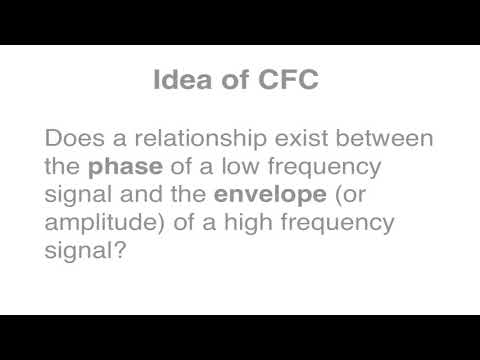

In [7]:
YouTubeVideo('JjOcJy4dVzE')

To assess whether different frequency rhythms interact in the LFP recording, we implement a measure to calculate the CFC. The idea of CFC analysis, in our case, is to determine whether a relation exists between the phase of a low-frequency signal and the envelope or amplitude of a high-frequency signal. In general, computing CFC involves three steps. Each step contains important questions and encompasses entire fields of study. Our goal in this section is to move quickly forward and produce a procedure we can employ, investigate, and criticize. Continued study of CFC - and the associated nuances of each step - is an active area of [ongoing research](https://www.ncbi.nlm.nih.gov/pubmed/26549886).

### CFC analysis steps

* Filter the data into high- and low-frequency bands.

* Extract the amplitude and phase from the filtered signals.

* Determine if the phase and amplitude are related.

<a id="step1"></a>
### Step 1. Filter the Data into High- and Low-Frequency Bands.

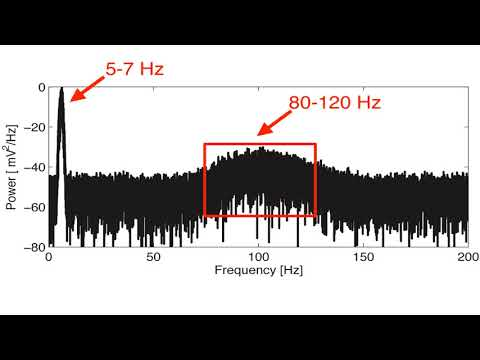

In [8]:
YouTubeVideo('WL_nFRBHqLU')

The first step in the CFC analysis is to filter the data into two frequency bands of interest. The choice is not arbitrary: the separate frequency bands are motivated by initial spectral analysis of the LFP data. In this case, we choose the low-frequency band as 5–7 Hz, consistent with the largest peak in the spectrum, and the high-frequency band as 80–120 Hz, consistent with the second-largest broadband peak. To consider alternative frequency bands, the same analysis steps would apply.

There are many options to perform the filtering. To do so requires us to design a filter that ideally extracts the frequency bands of interest without distorting the results. Here, we apply a finite impulse response (FIR) filter. We start by extracting the **low-frequency** band:

In [9]:
from scipy import signal
Wn = [5,7];                         # Set the passband [5-7] Hz,
n = 100;                            # ... and filter order,
                                    # ... build the bandpass filter,
b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vlo = signal.filtfilt(b, 1, LFP);   # ... and apply it to the data.

Next, we extract the **high-frequency** band:

In [10]:
Wn = [80, 120];                     # Set the passband [80-120] Hz,
n = 100;                            # ... and filter order,
                                    # ... build the bandpass filter,
b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vhi = signal.filtfilt(b, 1, LFP);   # ... and apply it to the data.

For each frequency band, we specify a frequency interval of interest by defining the low- and high-cutoff frequencies in the variable `Wn`. In this way, we specify the passband of the filter. We then set the filter order (`n`) and design the filter using the Python function `signal.firwin` from the [SciPy package](https://scipy.org/). Finally, we apply the filter using the Python function `signal.filtfilt`, which performs zero-phase filtering by applying the filter in both the forward and reverse directions.  We note that, in this case, the filtering procedure is nearly the same in both frequency bands; the only change is the specification of the frequency interval of interest.

To understand the impact of this filtering operation on the LFP, let’s plot the results. More specifically, let's plot the original signal, and the signal filtered in the low- and high-frequency bands, for an example 2 s interval of time:<a id="fig:7.3"></a>

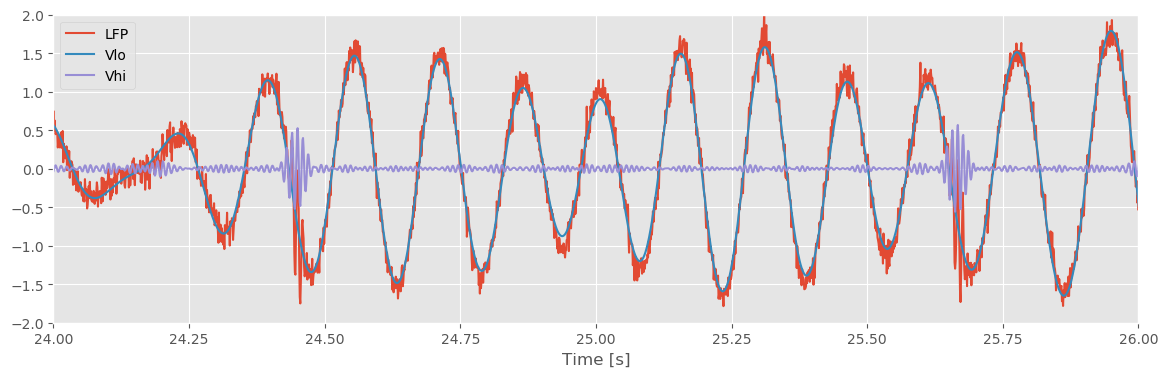

In [11]:
plt.figure(figsize=(14, 4))         # Create a figure with a specific size.
plt.plot(t, LFP)                    # Plot the original data vs time.
plt.plot(t, Vlo)                    # Plot the low-frequency filtered data vs time.
plt.plot(t, Vhi)                    # Plot the high-frequency filtered data vs time.
plt.xlabel('Time [s]')
plt.xlim([24, 26]);                 # Choose a 2 s interval to examine
plt.ylim([-2, 2]);
plt.legend(['LFP', 'Vlo', 'Vhi']);  # Add a legend.

As expected, the low-frequency band (orange) captures the large-amplitude rhythm dominating the LFP signal, while the higher-frequency band (green) isolates the brief bursts of faster activity.

<a id="step2"></a>
### Step 2. Extract the Amplitude and Phase from Filtered Signals.

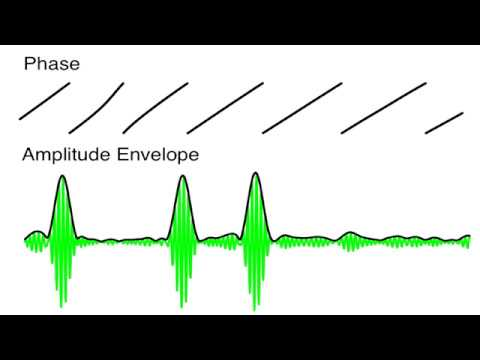

In [12]:
YouTubeVideo('QiRuBvbCQt4')

The next step in the CFC procedure is to extract the *phase* of the low-frequency signal and the amplitude envelope (or simply, *amplitude*) of the high-frequency signal. To compute a particular type of CFC, namely phase-amplitude coupling, we then compare these two signals, i.e., we compare the phase of the low-frequency activity and the amplitude envelope of the high-frequency activity. How do we actually extract the phase and amplitude signals from the data? There are a variety of options to do so, and we choose here to employ the **analytic signal approach**, which allows us to estimate the instantaneous phase and amplitude envelope of the LFP.

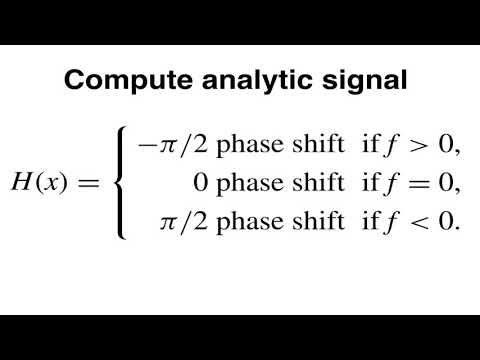

In [13]:
YouTubeVideo('Ir8Gf550S3o')

The first step in computing the analytic signal is to compute the [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform). We begin with some notation. Define $x$ as a narrowband signal (i.e., a signal with most of its energy concentrated in a narrow frequency range<sup> <abbr title="The impact of this narrowband assumption on CFC estimates remains an open research topic. One might consider, for example, the meaning and implications of estimating phase from a broadband signal, and the impact on subsequent CFC results.">note</abbr></sup>, e.g., the low- or high-frequency band filtered signals we've created). Then the Hilbert transform of $x$, let’s call it $y$, is

$$y = H(x).$$

It’s perhaps more intuitive to consider the effect of the Hilbert Transform on the frequencies
$f$ of $x$,

$$
\begin{equation}
    H(x)=
    \begin{cases}
      -\pi/2 & \text{ phase shift if } f>0 \\
      0 & \text{ phase shift if } f=0 \\
      \pi/2 & \text{ phase shift if } f<0 \\
    \end{cases}
  \end{equation}
$$

<div class="math-note">
    
**To summarize**:  The Hilbert transform $H(x)$ of the signal $x$ produces a phase shift of $\pm 90$ degrees for $\mp$ frequencies of $x$.
    
</div>

The Hilbert Transform can also be described in the time domain, although its representation is hardly intuitive (see this [Appendix](#appendix) for more details). Then the analytic signal $z$ is

$$ z = x + i y = x + i H(x). $$

The effect of the Hilbert transform is to remove negative frequencies from $z$. As it stands,
this is not obvious. To get a sense for why this is so, let’s consider a simple example.

<a id="hilbert"></a>
### What Does the Hilbert Transform Do?
[Skip this section](#step2ctd)

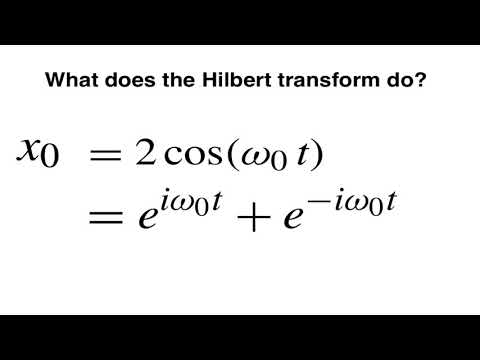

In [14]:
YouTubeVideo('-CjnFEOopfw')

Let $x_0$ be a sinusoid at frequency $f_0$, 

$$ x_0 = 2 \cos(2 \pi f_0 t) = 2 \cos(\omega_0 t),$$

where to simplify notation we have defined $\omega_0 = 2 \pi f_0$. We know from [Euler’s formula](https://en.wikipedia.org/wiki/Euler%27s_formula) that
<a id="eq:7.3"></a>

$$x_0 = e^{i \omega_0 t} + e^{-i \omega_0 t}.$$

The real variable $x_0$ possesses both a positive and a negative frequency component (i.e., $\omega_0$ and $-\omega_0$). So, the spectrum has two peaks:

<img src="imgs/7-5.png" alt="Drawing" style="width: 500px;"/>

For real signals, which include nearly all recordings of brain activity, the negative frequency component is redundant, and we usually ignore it. However, the negative frequency component still remains. By definition, the effect of the Hilbert transform is to induce a phase shift. For positive frequencies, the phase shift is  $-\pi/2$. We can produce this phase shift by multiplying the positive frequency part of the signal by $-i$.

<div class="question">
    
**Q:** Why does a phase shift of  $-\pi/2$ correspond to multiplication by $-i$?

**A:** Consider the complex exponential $e^{i \omega_0 t}$, which consists of only a positive frequency component ($\omega_0$). This signal shifted in phase by $-\pi/2$ corresponds to the new signal $e^{i (\omega_0 t - \pi / 2)}$, which simplifies to

$$e^{i \omega_0 t} e^{-i\pi/2} = e^{i\omega_0 t}\big(\cos(\pi/2) - i \sin(\pi/2)\big) = e^{i\omega_0 t} (-i).$$

Notice the result simplifies to the original complex exponential $e^{i\omega_0 t}$ multiplied by $-i$. This shows that the $-\pi/2$ phase shift corresponds to multiplication of the positive frequency component $(e^{i\omega_0 t})$ by $-i$.
    
</div>

<div class="question">
    
**Q.** Can you show that a $\pi / 2$ phase shift corresponds to multiplication by $i$? 
    
</div>

This analysis shows that we can represent the Hilbert transform of $x$ at frequency $f$ as

$$ H(x) = \left\{\begin{array}{r}
-ix \mbox{ if } f > 0, \\
0 \mbox{ if } f = 0, \\
ix \mbox{ if } f < 0.
\end{array}\right.$$

Therefore, the Hilbert transform of $x_0 = e ^ {i \omega_0 t} + e ^ {-i \omega_0 t}$ becomes

$$y_0 = H(x_0) = -i e ^ {i \omega_0 t} + i e ^ {-i \omega_0 t}. $$

In this equation, we multiply the positive frequency part of $x_0$ (i.e., $e ^ {-i \omega_0 t}$) by $i$. Simplifying this expression using Euler's formula, we find

$$ y_0 = 2 \sin( \omega_0 t ).$$

<div class="question">
    
**Q.** Can you perform this simplification? In other words, can you show that $-i e ^ {i \omega_0 t} + i e ^ {-i \omega_0 t} = 2 \sin( \omega_0 t )$? 
    
</div>

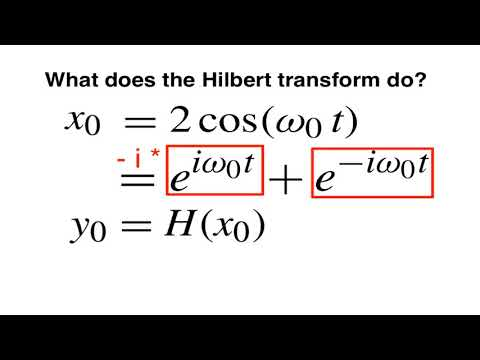

In [15]:
YouTubeVideo('e4kECy8KP-4')

The Hilbert transform of $x_0$ (a cosine function) is a sine function. We could perhaps have guessed this: sine is a 90-degree ($\pi / 2$) phase shift of cosine.

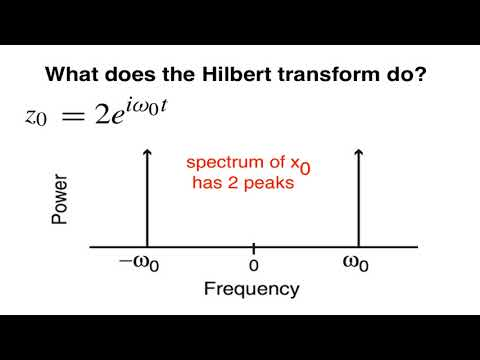

In [16]:
YouTubeVideo('emsU97RcFjI')

We are now ready to define the analytic signal $(z_0)$ for this example. Using the expressions for $x_0$ and $y_0$ and Euler's formula, we find

$$z_0 = x_0 + i y_0 = 2 \cos( \omega_0 t ) + i 2 \sin(\omega_0 t ) = 2 e ^ {i \omega_0 t}.$$

Notice that this analytic signal $z_0$ contains no negative frequencies; as mentioned, the effect of the Hilbert transform is to eliminate the negative frequencies from $x$. The spectrum of this signal consists of a single peak at $\omega_0$, compared to the two peaks at $\pm \omega_0$ in the original signal $x$. In this sense, the analytic signal ($z_0$) is simpler than the original signal $x_0$. To express the original signal $x_0$ required two complex exponential functions,

$$x_0 = e^{i \omega_0 t} + e^{-i \omega_0 t},$$

compared to only one complex exponential required to express the corresponding analytic signal $z_0$. There's an interesting geometrical interpretation of this. Consider plotting $x_0$ in the complex plane:

<img id="fig:7.6" src="imgs/7-6.png" style="width:30vw"></img>

Because $x_0$ is real, this quantity evolves in time along the real axis (red in the figure). To keep $x_0$ on the real axis, the two complex exponentials (orange in the figure) that define $x_0$ (i.e., $e^{i \omega_0 t}$ and $e^{-i \omega_0 t}$) rotate in opposite directions along the unit circle (blue in the figure). By doing so, the imaginary components of these two vectors cancel, and we're left with a purely real quantity $x_0$.

<div class="question">
    
**Q.** The phase of a complex quantity is the angle with respect to the real axis in the complex plain. What is the angle of $x_0$ in the figure above? 
    
</div>

<a id="step2ctd"></a>
### Step 2. Extract the Amplitude and Phase from Filtered Signals (Continued).

Having developed some understanding of the Hilbert Transform, let’s now return to the LFP data of interest here. It’s relatively easy to compute the analytic signal and extract the phase and amplitude in Python:

In [17]:
phi = np.angle(signal.hilbert(Vlo))  # Compute phase of low-freq signal
amp = abs(signal.hilbert(Vhi))       # Compute amplitude of high-freq signal

These operations require just two lines of code. But beware the following.

<div class="python-note">
    
**Alert!** The command `hilbert(x)` returns the analytic signal of $x$, not the Hilbert transform of $x$.
    
</div>

To extract the phase, we apply the function `angle` to the analytic signal of the data filtered in the low-frequency band (variable `Vlo`). We then extract the amplitude of the analytic signal of the data filtered in the high-frequency band (variable `Vhi`) by computing the absolute value (function `abs`).

To summarize, in this step we apply the Hilbert transform to create the analytic signal and get the phase or amplitude of the bandpass-filtered data.

<a id="step3"></a>
### Step 3. Determine if the Phase and Amplitude are Related.

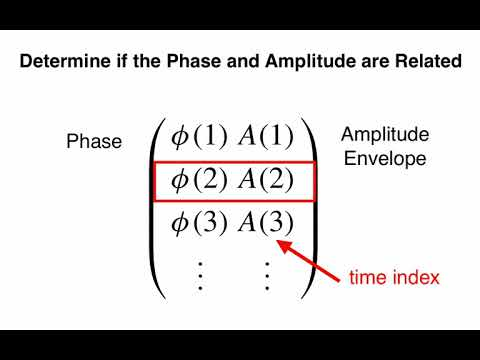

In [18]:
YouTubeVideo('fiL9UNbLPA8')

As with the previous steps, we have at our disposal a variety of procedures to assess the relation between the phase (of the low-frequency signal) and amplitude (of the high-frequency signal). We do so here in one way, by computing the phase-amplitude plot.

<a id="m1"></a>
### The phase-amplitude plot

To start, define the two-column phase-amplitude vector,

$$\left( \begin{array}{cc}
\phi(1) & A(1) \\
\phi(2) & A(2) \\
\phi(3) & A(3) \\
\vdots & \vdots \\
\end{array}\right),$$

where $\phi(i)$ is the phase of the low-frequency band activity at time index $i$, and $A(i)$ is the amplitude of the high-frequency band activity at time index $i$. In other words, each row defines the instantaneous phase and amplitude of the low- and high-frequency filtered data, respectively.

We now use this two-column vector to assess whether the phase and amplitude envelope are related. Let's begin by plotting the average amplitude versus phase. We divide the phase interval into bins of size 0.1 beginning at $-\pi$ and ending at $\pi.$ the choice of bin size is somewhat arbitrary; this choice will work fine, but you might consider the impact of other choices.

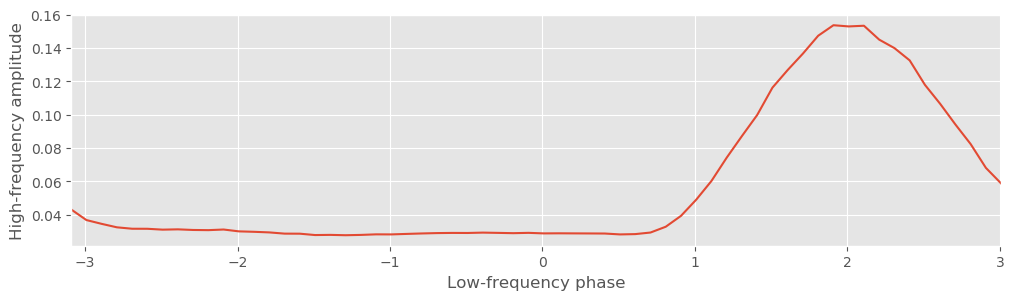

In [19]:
p_bins = np.arange(-np.pi, np.pi, 0.1)
a_mean = np.zeros(np.size(p_bins)-1)
p_mean = np.zeros(np.size(p_bins)-1)
for k in range(np.size(p_bins)-1):
    pL = p_bins[k]					    #... lower phase limit,
    pR = p_bins[k+1]				    #... upper phase limit.
    indices=(phi>=pL) & (phi<pR)	    #Find phases falling in bin,
    a_mean[k] = np.mean(amp[indices])	#... compute mean amplitude,
    p_mean[k] = np.mean([pL, pR])		#... save center phase.
plt.plot(p_mean, a_mean)                #Plot the phase versus amplitude,
plt.ylabel('High-frequency amplitude')  #... with axes labeled.
plt.xlabel('Low-frequency phase');

<div class="question">
    
**Q.** Consider this plot of the average amplitude versus phase. Does this result suggest CFC occurs in these data?

**A.** The plot shows the phase bins versus the mean amplitude in each bin. Visual inspection of this phase-amplitude plot suggests that the amplitude of the high-frequency signal depends on the phase of the low-frequency signal. In particular, we note that when the phase is near a value of 2 radians, the amplitude tends to be large, while at other phases the amplitude is smaller. This conclusion suggests that CFC does occur in the data; the high-frequency amplitude depends on the low-frequency phase.
    
</div>

<div class="question">
    
**Q.** If no CFC occurred in the data, what would you expect to find in the plot of average amplitude versus phase? 
    
</div>

As a basic statistic to capture the extent of this relation, we compute the difference between the maximum and minimum of the average amplitude envelope over phases. Let's assign this difference the label $h$. In Python,

In [20]:
h = max(a_mean)-min(a_mean)
print(h)

0.12607449865513892


We find a value of $h = 0.126$. This value, on its own, is difficult to interpret. Is it bigger or smaller than we expect? To assess the significance of $h$, let's generate a surrogate phase-amplitude vector by resampling without replacement the amplitude time series (i.e., the second column of the phase-amplitude vector). Resampling is a powerful technique that we have applied in our analysis of other case study data (see, for example, 
[The Event-Related Potential](../The%20Event-Related%20Potential/The%20Event-Related%20Potential.ipynb)). By performing this resampling, we reassign each phase an amplitude chosen randomly from the entire 100 s LFP recording. We expect that if CFC does exist in these data, then the timing of the phase and amplitude vectors will be important; for CFC to occur, the amplitude and phase must coordinate in time. By disrupting this timing in the resampling procedure, we expect to eliminate the coordination between amplitude and phase necessary to produce CFC.

For each surrogate phase-amplitude vector, we compute the statistic $h$. To generate a distribution of $h$ values, let’s repeat 1,000 times this process of creating surrogate data through resampling and computing $h$.

In [21]:
n_surrogates = 1000;                       #Define no. of surrogates.
hS = np.zeros(n_surrogates)                #Vector to hold h results.
for ns in range(n_surrogates):             #For each surrogate,
    ampS = amp[np.random.randint(0,N,N)]   #Resample amplitude,
    p_bins = np.arange(-np.pi, np.pi, 0.1) #Define the phase bins
    a_mean = np.zeros(np.size(p_bins)-1)   #Vector for average amps.
    p_mean = np.zeros(np.size(p_bins)-1)   #Vector for phase bins.
    for k in range(np.size(p_bins)-1):
        pL = p_bins[k]					    #... lower phase limit,
        pR = p_bins[k+1]				    #... upper phase limit.
        indices=(phi>=pL) & (phi<pR)	    #Find phases falling in bin,
        a_mean[k] = np.mean(ampS[indices])	#... compute mean amplitude,
        p_mean[k] = np.mean([pL, pR])		#... save center phase.
    hS[ns] = max(a_mean)-min(a_mean)        # Store surrogate h.

In this code, we first define the number of surrogates (variable `n_surrogates`) and a vector to store the statistic $h$ computed for each surrogate phase-amplitude vector (variable `hS`). Then, for each surrogate, we use the Python function `random.randint` to randomly permute the amplitude vector without replacement. We then use this permuted amplitude vector (variable `ampS`) and the original phase vector (variable `phi`) to compute $h$; this last step utilizes the Python code developed earlier to compute `h` for the original (unpermuted) data.

Let's now view the results of this resampling procedure by creating a histogram of the variable `hS`, and compare this distribution to the value of `h` we computed earlier.

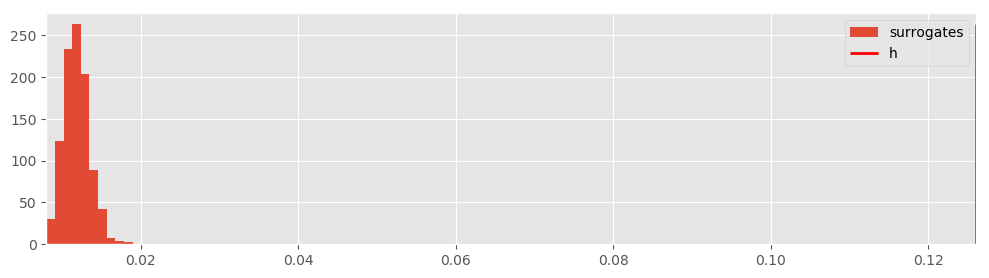

In [22]:
counts, _, _ = plt.hist(hS, label='surrogates')               # Plot the histogram of hS, and save the bin counts.
plt.vlines(h, 0, max(counts), colors='red', label='h', lw=2)  # Plot the observed h,
plt.legend();                                                 # ... include a legend.

The value of $h$ computed from the original data (`h`) lies far outside the distribution of surrogate $h$ values (`hS`). To compute a $p$-value, we determine the proportion of surrogate $h$ values greater than the observed $h$ value:

In [23]:
p = sum([s > h for s in hS]) / len(hS)
print(p)

0.0


We find a $p$-value that is very small; there are no surrogate values of $h$ that exceed the observed value of $h$. We therefore conclude that in this case the observed value of $h$ is significant. As a statistician would say, we reject the null hypothesis of *no* CFC between the phase of the 5-7 Hz low-frequency band and the amplitude of the 80-120 Hz high frequency band.

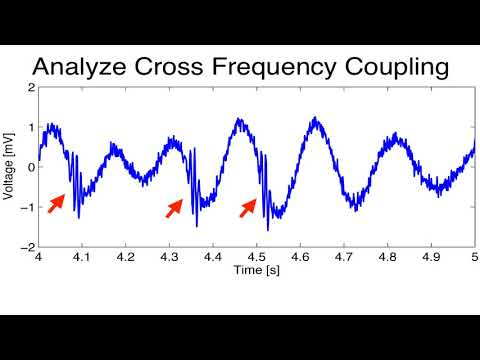

In [24]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('NQUfELSZ0Cc')

<a id="summary"></a>
# Summary

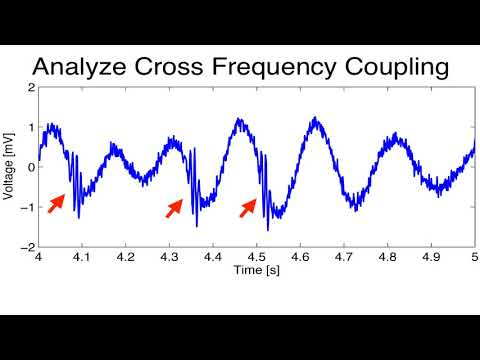

In [25]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('NQUfELSZ0Cc')

In this module, we considered techniques to characterize cross-frequency coupling (CFC), associations between rhythmic activity observed in two different frequency bands. To do so, we introduced the Hilbert transform, which can be used to compute the instantaneous phase and amplitude of a signal. We focused on characterizing the relation between the phase of low-frequency band activity (5-7 Hz) and the amplitude of high-frequency band activity (100-140 Hz). To do this, we computed the average amplitude at each phase and determined the extent of the variability (or wiggliness). 

For the LFP data of interest here, we found evidence of CFC between the two frequency bands. Importantly, these results also appear consistent with visual inspection of the unfiltered data. Careful inspection of the example voltage traces suggests that CFC does in fact occur in these data. In general, such strong CFC, visible to the naked eye in the unprocessed LFP data, is unusual. Instead, data analysis techniques are required to detect features not obvious through visual inspection alone. Developing techniques to assess CFC and understanding the biophysical mechanisms of CFC and implications for function, remain active research areas.

In developing these approaches, we utilized expertise and procedures developed in other modules. In particular, we relied on the notions of frequency and power, amplitude and phase, filtering, and resampling. Such a multifaceted approach is typical in analysis of neural data, where we leverage the skills developed in analyzing other datasets.

<a id="appendix"></a>
## Appendix: Hilbert Transform in the Time Domain

We have presented the Hilbert Transform in the frequency domain: it produces a quarter cycle phase shift. It's reasonable to consider as well the *time domain* representation of the Hilbert Transform. To do so, let's write the Hilbert Transform as

$$H(x) = \left\{ \begin{array}{rl}
-ix & \mbox{for positive frequencies of }x \\
0 & \mbox{for 0 frequency of }x \\
ix & \mbox{for negative frequencies of }x \\
\end{array}\right\} = x(f)\big( -i\mbox{sgn}(f)\big),$$

where we have written $x(f)$ to make the frequency dependence of $x$ explicit, and the sgn (pronounced "sign") function is defined as

$$\mbox{sgn}(f) = \left\{ \begin{array}{rl}
1 & \mbox{if }f > 0, \\
0 & \mbox{if }f = 0, \\
-1 & \mbox{if }f < 0, \\
\end{array}\right.$$

In the frequency domain, we perform the Hilbert Transform by multiplying the signal $x(f)$ by a constant (either $i$ or $-i$ depending on the frequency $f$ of $x$).

To convert the Hilbert transform in the frequency domain to the Hilbert Transform in the time domain, we take the inverse Fourier transform. Looking up the inverse Fourier transform of $-i\mbox{sgn}(f)$, we find

$$\mbox{Inverse Fourier transform}\{-i\mbox{sgn}(f)\} = \frac{1}{\pi t}.$$

Let's represent the inverse Fourier transform of $x(f)$ as $x(t)$.

Now, let's make use of an important fact. Multiplication of two quantities in the frequency domain corresponds to convolution of these two quantities in the time domain (see [Analysis of Rhythmic Activity in an Electrocorticogram](../Analysis%20of%20Rhythmic%20Activity%20in%20an%20Electrocorticogram/Analysis%20of%20rhythmic%20activity%20in%20the%20Electrocorticogram.ipynb)). The convolution of two signals $x$ and $y$ is 

$$ x * y = \int_{-\infty}^{\infty}x(\tau)y(t-\tau)d\tau.$$

So, in the time domain, the Hilbert transform becomes

$$H(x) = x(t) * \frac{1}{\pi t} = \frac{1}{\pi}\int_{-\infty}^{\infty}\frac{x(\tau)}{t-\tau}d\tau.$$

This time domain representation of the HIlbert Transform is equivalent to the frequency domain representation. However, the time domain representation is much less intuitive. Compare the previous equation to the statement, "*The Hilbert Transform is a 90-degree phase shift in the frequency domain.*" The latter, we propose, is much more intuitive.

In [ ]:
from IPython.core.display import HTML
HTML('../../assets/custom/custom.css')